 
# Predict TripAdvisor Rating
### Цель: 
 
Предсказать рейтинг ресторана в TripAdvisor и получить Mean Absolute Error (MAE) < 0.2
 
### Задачи:
 
- Сделать предобработку различных данных
- Обработать пропущенные данные (Nan)
- Кодировать и получить новые признаки
(Feature Engineering)

# Import

In [74]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings; warnings.simplefilter('ignore') #ignore warnings

# We load a special convenient tool for splitting a dataset:
from sklearn.model_selection import train_test_split

# fix the version of packages and seed so that experiments are reproducible: 
RANDOM_SEED = 42
!pip freeze > requirements.txt

# function for finding the city average
def fill_na(column): # get column
  city_list = data.City.unique() # finding unique values in cities
  for city in city_list:
    mean_price = data[column][data['City']==city].mean() # find mean for column
    data[column][data['City']==city] = data[column][data['City']==city].fillna(mean_price) # filling NaN values
  return data

# function for create conbine feature from dummy values
def dummy(column):
  column = column.apply(lambda x: x-x.mean()) # subtract mean
  column = column.apply(lambda x: x/np.linalg.norm(x)) # normalization
  column = [column.iloc[x].sum() for x in range(len(column))] # summing values in row
  column = column / np.linalg.norm(column) # normalization
  return column

## DATA

In [75]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [4]:
df_test.info()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [6]:
sample_submission.info()
sample_submission.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [76]:
# for correct processing of features, combine the train and test into one dataset
df_train['sample'] = 1 # mark where we have train
df_test['sample'] = 0 # mark where we have the test
df_test['Rating'] = 0 # in the test we do not have the Rating value, we must predict it, so for now we just fill it with zeros

data = df_test.append(df_train, sort=False).reset_index(drop=True) # unite

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


More on the signs:

- City: City
- Cuisine Style: Cuisine
- Ranking: Rank of the restaurant relative to other restaurants in the city
- Price Range: Restaurant prices in 3 categories
- Number of Reviews: Number of Reviews
- Reviews: 2 most recent reviews and the dates of these reviews
- URL_TA: Restaurant page on 'www.tripadvisor.com'
- ID_TA: ID of the restaurant on TripAdvisor
- Rating: Rating of the restaurant

In [69]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
11517,id_3355,Madrid,"['Italian', 'Pizza']",3357.0,$$ - $$$,46.0,[['Glutenfree food impossible/ Comida sin glu....,/Restaurant_Review-g187514-d2649839-Reviews-Pi...,d2649839,1,4.0
16500,id_412,Budapest,"['European', 'Eastern European', 'Central Euro...",413.0,$$ - $$$,77.0,"[['Great exprience', 'Perfect for the Hungary ...",/Restaurant_Review-g274887-d12215095-Reviews-S...,d12215095,1,4.5
49767,id_4359,Barcelona,NaN,4360.0,NaN,NaN,"[['fantastic value and service'], ['03/01/2013']]",/Restaurant_Review-g187497-d1081683-Reviews-Mo...,d1081683,1,5.0
5451,id_5451,Paris,NaN,9116.0,NaN,5.0,"[[], []]",/Restaurant_Review-g187147-d1335902-Reviews-Al...,d1335902,0,0.0
34813,id_1504,Brussels,['Italian'],1505.0,NaN,17.0,"[['Real Italian pasta', 'home made'], ['07/20/...",/Restaurant_Review-g188644-d740564-Reviews-Ago...,d740564,1,4.5


## Cleaning and Prepping Data

### 1. 'City'

In [77]:
data['city_norm'] = dummy(pd.get_dummies(data.City)) 
data.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,city_norm
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,-0.004292
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,0.010202
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0.006097
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,-0.004700
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,0.012611


<AxesSubplot:>

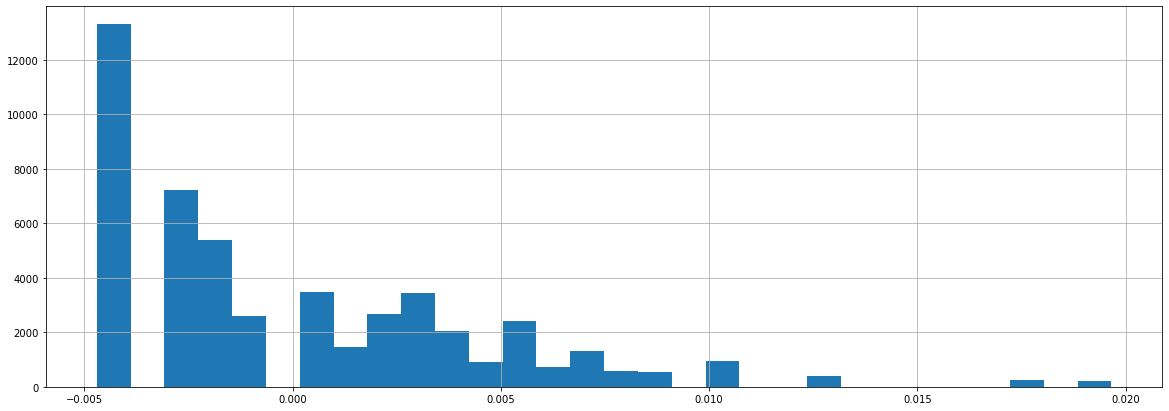

In [25]:
plt.rcParams['figure.figsize'] = (20,7)
data['city_norm'].hist(bins=30)

### 2. 'Cuisine Style'

In [78]:
# create two new features: a feature based on all unique cuisines and their number in the restaurant

cuisines = [] # rows dummy
cuis_dict = {} # for saving index cuisine in list
cuis_count = [] # for saving cuisines count

# create dummy values for cuisines
for index in data.index:
  string = data['Cuisine Style'][index] # copping value of cuisines
  if str(string) != 'nan':
    i=0 # index of string
    j=0 # count of cuisines
    
    # the new row in list filled with zeros depending on the number of keys in the dictionary:
    cuisines.append([0 for x in range(len(cuis_dict))]) 
    
    while i<len(string)-1:
      str_cuis = string.find("'",string.find("'",i)+1) # the index of the next apostrophe in the string 
      cuisine = string[string.find("'",i)+1:str_cuis] # cut cuisine from string
      
      if cuisine not in cuis_dict.keys(): # new cuisine
        cuis_dict[cuisine] = len(cuis_dict) # save index cuisine
        cuisines[index].append(1) # save '1' in end of list
      else:
        cuisines[index][cuis_dict[cuisine]] = 1
      
      i = str_cuis + 1 # next symbol
      j += 1 # plus cuisine
    cuis_count.append(j) # save count
  else: 
    cuis_count.append(None) 
    cuisines.append([None for x in range(len(cuis_dict))])  

# create new feature
cuisines = pd.DataFrame(cuisines, columns = list(cuis_dict.keys())) 
cuisines = cuisines.dropna(how='all') # delete empty rows
cuisines = cuisines.fillna(0) # fill NaN zeros
cuis_undex = cuisines.index # save index
cuisines = dummy(cuisines) # create dummy
cuisines = pd.DataFrame({'cuis_norm':cuisines}, index=cuis_undex) # create dataframe with values and empty rows

# fill empty row in cuisines
data = pd.concat([data,cuisines], axis=1) # concatanate tables
data = fill_na('cuis_norm') # fill empty

# create new column with count in data and fill empty values
data['cuis_count'] = cuis_count
data = fill_na('cuis_count')

data.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,city_norm,cuis_norm,cuis_count
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,-0.004292,-0.003014,2.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,0.010202,0.002108,5.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0.006097,-0.005033,1.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,-0.004700,-0.000846,5.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,0.012611,0.001082,6.0


<AxesSubplot:>

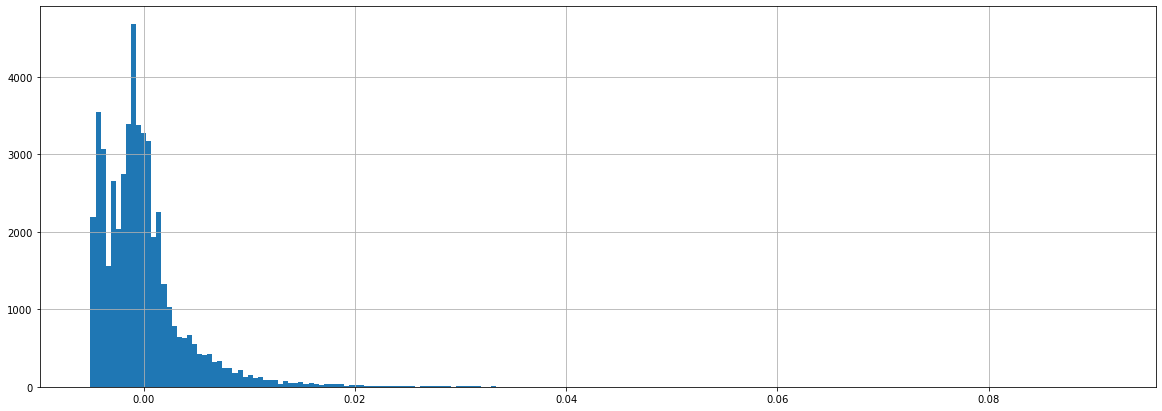

In [49]:
plt.rcParams['figure.figsize'] = (20,7)
data['cuis_norm'].hist(bins=200)

<AxesSubplot:>

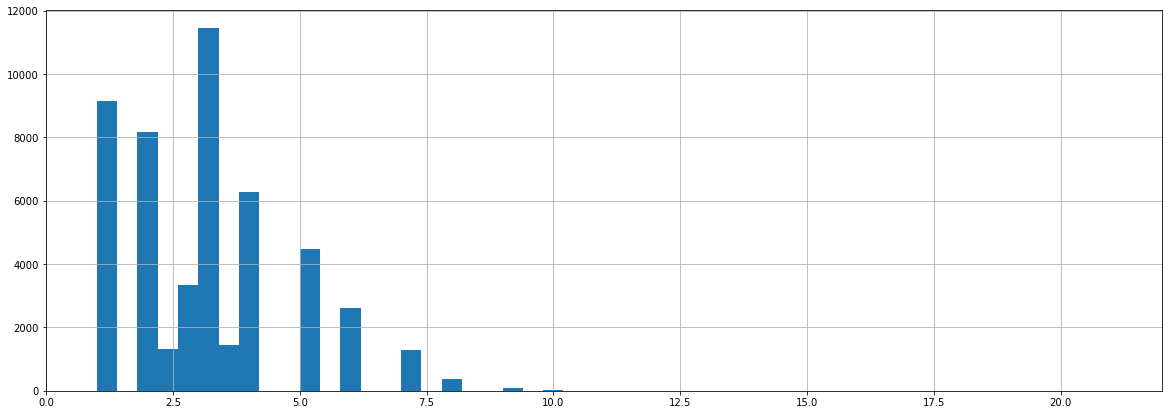

In [42]:
plt.rcParams['figure.figsize'] = (20,7)
data['cuis_count'].hist(bins=50)

### 3. 'Price Range'

In [79]:
# create dictionary and fill empty values:

price_dict = {'$':1,'$$ - $$$':2,'$$$$':3}
data['Price Range'] = data['Price Range'].replace(to_replace=price_dict)

data = fill_na('Price Range') 
data.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,city_norm,cuis_norm,cuis_count
0,id_0,Paris,"['Bar', 'Pub']",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,-0.004292,-0.003014,2.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,0.010202,0.002108,5.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,2.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0.006097,-0.005033,1.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3.0,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,-0.004700,-0.000846,5.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3.0,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,0.012611,0.001082,6.0


<AxesSubplot:>

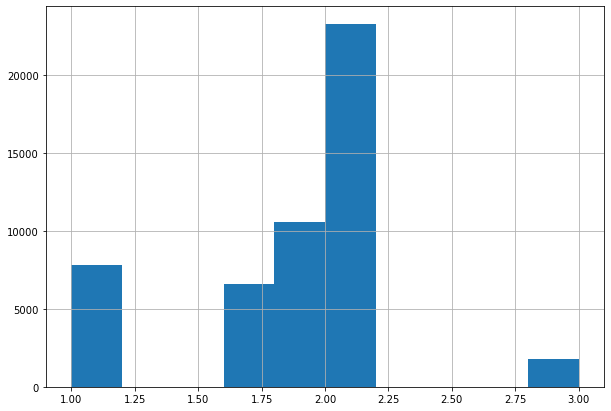

In [47]:
plt.rcParams['figure.figsize'] = (10,7)
data['Price Range'].hist(bins=10)

### 4. 'Number of Reviews'

In [80]:
data = fill_na('Number of Reviews') 
data.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,city_norm,cuis_norm,cuis_count
0,id_0,Paris,"['Bar', 'Pub']",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,-0.004292,-0.003014,2.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,0.010202,0.002108,5.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,2.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0.006097,-0.005033,1.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3.0,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,-0.004700,-0.000846,5.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3.0,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,0.012611,0.001082,6.0


<AxesSubplot:>

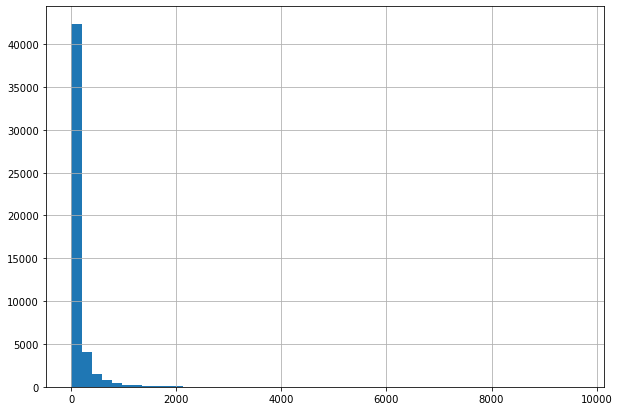

In [85]:
plt.rcParams['figure.figsize'] = (10,7)
data['Number of Reviews'].hist(bins=50)

### 5. 'Reviews'

In [86]:
# created new features: days count between reviews and length reviews

pattern_time = re.compile('\d\d\/\d\d\/\d+') # patern for time
pattern_text = re.compile('[A-Za-z ]+') # pattern for text
time1 = []
time2 = [] 
len_text = [] 
 
for i in data.index:
  if str(data.Reviews[i]) == 'nan':
    data.Reviews[i] = '[[], []]'
  
  t_values = pd.to_datetime(pattern_time.findall(data.Reviews[i])) # find time string and transform it in time
    
  # save string lenth:
  if len(data.Reviews[i]) != 8:
    len_text.append(len(str(pattern_text.findall(data.Reviews[i]))))
  else: # if string lenth is eight than it empty
    len_text.append(None) 
  
  # save time:
  if len(t_values) == 0:
    time1.append(None)
    time2.append(None) 
  elif len(t_values) == 1:
    time1.append(t_values[0])
    time2.append(None) 
  else:
    time1.append(t_values[0])
    time2.append(t_values[1]) 

time = pd.DataFrame({'time1':time1, 'time2':time2})  
data['time_change'] = abs(time.time1-time.time2) # calculate difference

# transform in integer type and filling empty for time:
data['time_change'] = data['time_change'].apply(lambda x: int(x.days) if str(x.days) != 'nan' else None) 
data = fill_na('time_change')

# saving length and filling empty for reviews:
data['len_reviews'] = len_text
data = fill_na('len_reviews')
data.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,city_norm,cuis_norm,cuis_count,time_change,len_reviews
0,id_0,Paris,"['Bar', 'Pub']",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,-0.004292,-0.003014,2.0,172.991084,66.201194
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,0.010202,0.002108,5.0,37.000000,64.000000
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,2.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0.006097,-0.005033,1.0,22.000000,53.000000
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3.0,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,-0.004700,-0.000846,5.0,14.000000,60.000000
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3.0,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,0.012611,0.001082,6.0,15.000000,72.000000


## EDA

<AxesSubplot:>

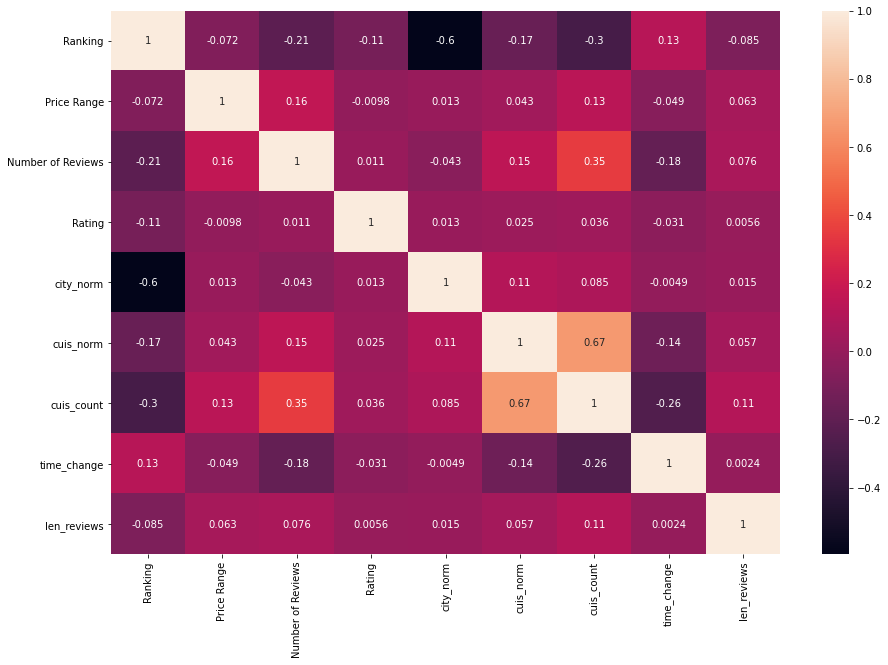

In [88]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),annot=True)

## Data Preprocessing

For convenience and reproducibility of the code, we will wrap all the processing in one big function

In [89]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        50000 non-null  float64
 5   Number of Reviews  50000 non-null  float64
 6   Reviews            50000 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
 11  city_norm          50000 non-null  float64
 12  cuis_norm          50000 non-null  float64
 13  cuis_count         50000 non-null  float64
 14  time_change        50000 non-null  float64
 15  len_reviews        50000 non-null  float64
dtypes: float64(9), int64(1

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,city_norm,cuis_norm,cuis_count,time_change,len_reviews
0,id_0,Paris,"['Bar', 'Pub']",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,-0.004292,-0.003014,2.0,172.991084,66.201194
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,0.010202,0.002108,5.0,37.000000,64.000000
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,2.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0.006097,-0.005033,1.0,22.000000,53.000000
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3.0,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,-0.004700,-0.000846,5.0,14.000000,60.000000
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3.0,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,0.012611,0.001082,6.0,15.000000,72.000000


In [90]:
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)
# Now let's select the test part
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # our target
X = train_data.drop(['Rating'], axis=1)

Before sending our data for training, we will divide the data into another test and train for validation. This will help us test how well our model is performing before submitting the submissiona to kaggle.

In [91]:
# Let's use the special function train_test_split to split test data
# allocate 20% of the data for validation (parameter test_size)
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.2, random_state = RANDOM_SEED)
# check
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 9), (40000, 9), (40000, 8), (32000, 8), (8000, 8))

## Model

Сам ML

In [92]:
# Import the required libraries:
from sklearn.ensemble import RandomForestRegressor # tool for creating and training the model
from sklearn import metrics # tools for assessing model accuracy

# Create the model (DO NOT HANDLE SETTINGS)
model = RandomForestRegressor (n_estimators = 100, verbose = 1, n_jobs = -1, random_state = RANDOM_SEED)

# Train the model on the test dataset
model.fit (X_train, y_train)

# We use a trained model to predict restaurant ratings in a test sample.
# The predicted values are written to the y_pred variable
y_pred = model.predict (X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.6s finished


In [93]:
# Compare the predicted values (y_pred) with the real ones (y_test), and see how much they differ on average
# The metric is called the Mean Absolute Error (MAE) and shows the average deviation of the predicted values from the actual ones.
print ('MAE:', metrics.mean_absolute_error (y_test, y_pred))

MAE: 0.217960625


<AxesSubplot:>

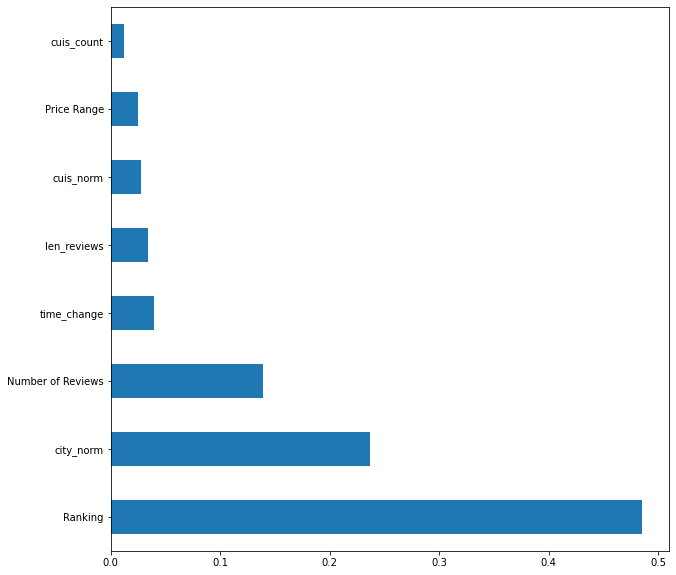

In [94]:
# in RandomForestRegressor it is possible to display the most important features for the model
plt.rcParams ['figure.figsize'] = (10,10)
feat_importances = pd.Series (model.feature_importances_, index = X.columns)
feat_importances.nlargest (15) .plot (kind = 'barh')

## Submission

If everything suits, prepare Submission for kaggle

In [95]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,Rating,city_norm,cuis_norm,cuis_count,time_change,len_reviews
1326,5367.0,1.743210,5.000000,0.0,-0.001544,-0.001024,3.004532,248.000000,76.000000
9558,16395.0,1.808891,137.968381,0.0,-0.004700,-0.003260,1.000000,100.210164,57.000000
8191,666.0,2.000000,13.000000,0.0,0.010202,0.001183,3.000000,226.000000,83.000000
8816,931.0,2.000000,12.000000,0.0,0.008108,-0.003499,2.000000,133.000000,95.000000
5787,4428.0,1.891774,33.000000,0.0,-0.004292,-0.001370,2.453125,172.991084,66.201194
9745,986.0,2.000000,31.000000,0.0,0.003733,0.005024,5.000000,47.000000,65.000000
7680,1874.0,2.000000,243.000000,0.0,-0.002451,-0.001662,4.000000,257.000000,84.000000
1583,5970.0,2.000000,34.000000,0.0,-0.002451,-0.003412,2.000000,120.000000,73.000000
2186,1152.0,1.668934,16.000000,0.0,0.007352,-0.000451,3.245935,1192.000000,77.000000
506,1817.0,1.000000,12.000000,0.0,-0.002865,-0.003581,2.000000,170.872397,46.000000


In [96]:
test_data = test_data.drop(['Rating'], axis=1)

sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [97]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished


In [98]:
predict_submission

array([3.035, 4.19 , 4.31 , ..., 3.05 , 4.495, 4.28 ])

In [99]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.035
1,id_1,4.190
2,id_2,4.310
3,id_3,4.290
4,id_4,4.385
5,id_5,4.335
6,id_6,1.700
7,id_7,2.435
8,id_8,4.090
9,id_9,4.605
